In [1]:
import pickle
with open("vonMisesData_100neurons.p", "rb") as input_file:
    [NumNeurons, NeuronParameters, WorldParameters, Neurons, 
     NumTrajectories, TrajStartPos, RatRadialSpeed, TrajLength, SpikeRasters,
     dT, RandomWalkSigma, TrajStartPos_RW, RandomWalkTraj, SpikeRasters_RW] = pickle.load(input_file)

In [2]:
# All imports here...
import numpy as np

import time

from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# display place field coverage of a particular environment
sns.set(rc={'figure.figsize': (18, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")

/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
def BinSpikeRasters(Rasters, BinWidth=0.25, NBins=0) :
    # Rasters is a list of ndarrays, where each array contains spike times for a neuron
    if (NBins == 0) :
        b = 0.0;
        for spk_ts in Rasters :
            if (len(spk_ts) > 0) :
                b = max(b, (spk_ts[-1] / BinWidth))
        NBins = np.int(np.ceil(b))
    BinnedRasters = np.zeros((NBins, len(Rasters)))
    
    for k, spk_ts in enumerate(Rasters) :
        for s in spk_ts :
            BinnedRasters[np.int(s/BinWidth), k] += 1
    return BinnedRasters

In [4]:

t0 = time.time();
# Train model with first environment
NTrain = 50
NTest = 500
BinWidth = 0.25 # 250 ms bins
NBins = np.int(TrajLength / BinWidth)
TrainingData = []
for w in range(WorldParameters['NEnv']) :
    TrainingData.append([])
    for k in range(NTrain) :
        TrainingData[w].append(BinSpikeRasters(SpikeRasters[w][k], BinWidth=BinWidth, NBins=NBins))
t1 = time.time();
print("Time elapsed for binning: ", t1-t0)




Time elapsed for binning:  0.24055099487304688


In [5]:
StackedTrainingData = []
TrainingSequenceLengths = []
for w in range(WorldParameters['NEnv']) :
    StackedTrainingData.append(np.vstack(TrainingData[w]))
    TrainingSequenceLengths.append(np.zeros(NTrain, dtype=int))
    for idx,l in enumerate(TrainingData[w]) :
        (TrainingSequenceLengths[w][idx], ncols) = l.shape


In [6]:
# Compare different environments
Model = []
NStates = 10

transmat_init = np.zeros((NStates,NStates))
for i in range(NStates):
    for j in range(NStates) :
        if (i < j) :
            transmat_init[i][j] = 0.5**(np.abs(i-j))
        else :
            transmat_init[i][j] = 0.01**(np.abs(i-j))

from hmmlearn.utils import normalize
transmat_init = normalize(transmat_init, axis=1)


for w in range(WorldParameters['NEnv']) :
    model = hmm.PoissonHMM(n_components=NStates, n_iter=200, tol=1e-4, init_params='smc')
    model.transmat_ = transmat_init
    Model.append(model)
    #Model.append(hmm.GaussianHMM(n_components=NStates, covariance_type='diag', n_iter=100))


In [7]:
t0 = time.time();
   
for w in range(WorldParameters['NEnv']) :
    t1 = time.time();
    # Build an HMM instance and set parameters
    Model[w].fit(StackedTrainingData[w], lengths=TrainingSequenceLengths[w])
    t2 = time.time();
    print(t2-t1)
t3 = time.time();
print(t3-t0) # ~300 s total for 1000 neurons

2.9506468772888184
2.503571033477783
3.4349758625030518
6.526093006134033
5.490846872329712
20.907824993133545


/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


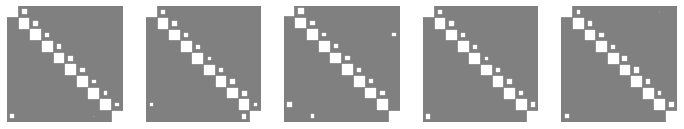

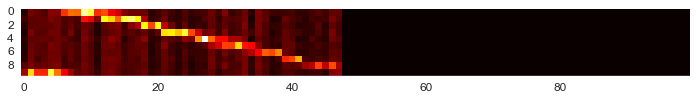

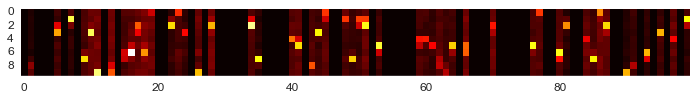

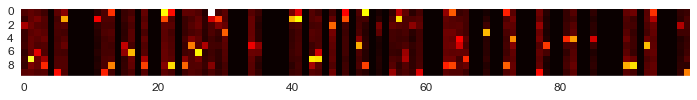

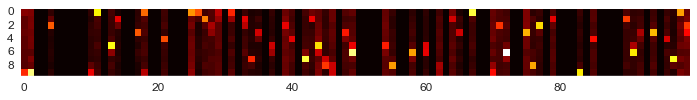

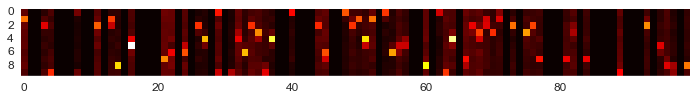

In [8]:
from hinton import hinton

def ArrangeTransitionMatrix(tmat, means) :
    [NStates, _] = tmat.shape
    new_order = [0]
    rem_states = np.arange(1,NStates).tolist()
    cs = 0

    for ii in np.arange(0,NStates-1):
        nstilde = np.argmax(tmat[cs,rem_states])
        ns = rem_states[nstilde]
        rem_states.remove(ns)
        cs = ns
        new_order.append(cs)

    tmatnew = tmat[:, new_order][new_order]
    meanmat = means[new_order,:]
    return [tmatnew, meanmat]

sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('dark')

fig1 = plt.figure()
f, axarr = plt.subplots(1,WorldParameters["NEnv"])
for k in range(WorldParameters["NEnv"]):
    [newtmat, newmeans] = ArrangeTransitionMatrix(Model[k].transmat_, Model[k].means_)
    plt.sca(axarr[k])
    hinton(newtmat.T)
    plt.figure()
    plt.imshow(newmeans, interpolation='none', cmap='hot')
   


In [9]:
SequenceLL = []
t1 = time.time();
for w in range(WorldParameters['NEnv']) :
    SequenceLL.append(np.zeros(NTest))
    
for w in range(WorldParameters['NEnv']) :
    for i in range(NTest) :
        SequenceLL[w][i] = Model[0].score(BinSpikeRasters(SpikeRasters[w][NTrain + i]))
    t2 = time.time();
    print(t2-t1)


0.8442349433898926
1.680487871170044
2.573948860168457
3.413541793823242
4.27783989906311


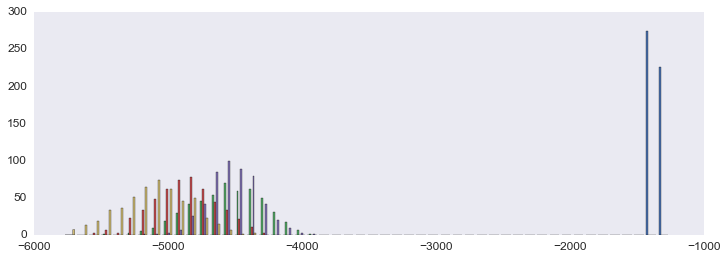

In [10]:
plt.hist(SequenceLL,bins=50);

/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


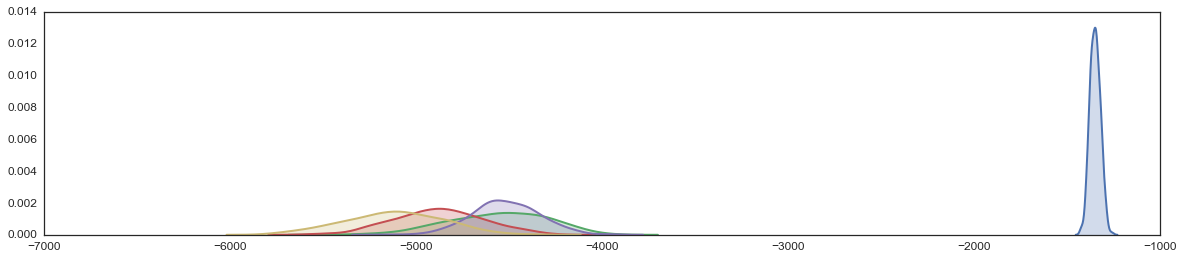

In [11]:
sns.set(rc={'figure.figsize': (20, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')
for modelLL in SequenceLL:
    sns.kdeplot(modelLL, shade=True)

In [27]:
# Examine random walk data and calculate model scores
RWSequenceLL = np.zeros(NTest)
    
for i in range(NTest) :
    RWSequenceLL[i] = Model[0].score(BinSpikeRasters(SpikeRasters_RW[0][NTrain + i]))

# Examine shuffles
NShuffles = 10
#  (1) Teleporation shuffle
TeleportLL = np.zeros(NTest*NShuffles)
for i in range(NTest) :
    data = BinSpikeRasters(SpikeRasters[0][NTrain + i])
    for j in range(NShuffles) :
        shuffledData = np.random.permutation(data)
        TeleportLL[i*NShuffles + j] = Model[0].score(shuffledData)

#  (2) NeuronID shuffle
NeuronIdLL = np.zeros(NTest*NShuffles)
#    find place cells
PlaceCells = np.zeros(NumNeurons)
for i,n in enumerate(Neurons) :
    if (n['PFHasField'][0]) :
        PlaceCells[i] = 1;
PlaceCellIndices = np.nonzero(PlaceCells)

for i in range(NTest) :
    data = BinSpikeRasters(SpikeRasters[0][NTrain + i])
    for j in range(NShuffles) :
        shuffledData = np.copy(data)
        shuffledData[:,PlaceCellIndices[0]] = shuffledData[:,np.random.permutation(PlaceCellIndices[0])]
        NeuronIdLL[i*NShuffles + j] = Model[0].score(shuffledData)


/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


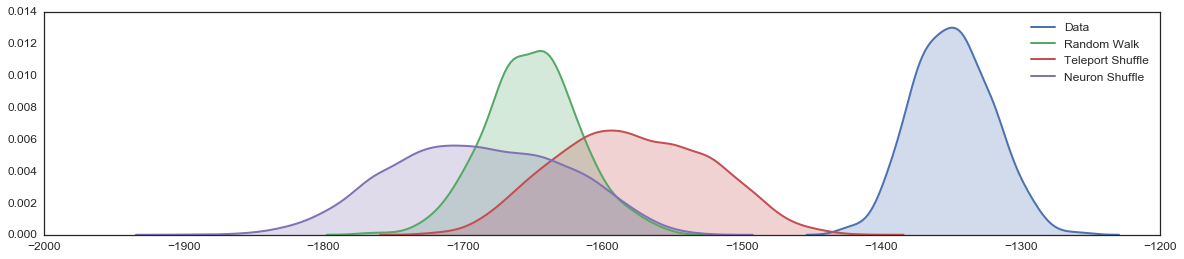

In [28]:
#sns.kdeplot([SequenceLL[0],RWSequenceLL, TeleportLL, NeuronIdLL]);
sns.set(rc={'figure.figsize': (20, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')
sns.kdeplot(SequenceLL[0], shade=True, label='Data')
sns.kdeplot(RWSequenceLL, shade=True, label='Random Walk')
sns.kdeplot(TeleportLL, shade=True, label='Teleport Shuffle')
sns.kdeplot(NeuronIdLL, shade=True, label='Neuron Shuffle')

